# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [1]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

plt.style.use(['ggplot'])

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


##Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer:

PCA is good for reducing the number of dimensions in a data set. It reduces the features into principal components which can then be thought of as new features. I expect the results will show me some insight into the buying behavior of different groupings of the wholesaler's customers. These segments may allow us to make some  prediction about what sort of customers belong to a particular grouping. For example if one component has high covariance with Delicatessen, chances are customer within this segment are Delis.

ICA can also be used for reducing the number of dimensions. We can use ICA here to find the hidden groupings of customers. Every component, or vector that is produced through ICA will contain a set of weightings for each feature within the initial set. For example, there could be a  component with a high weighting in Detergents_Paper, from which we could infer that this cohort is mostly convenience stores, such as CVS.

###PCA

[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]

[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


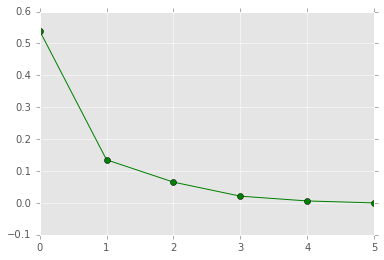

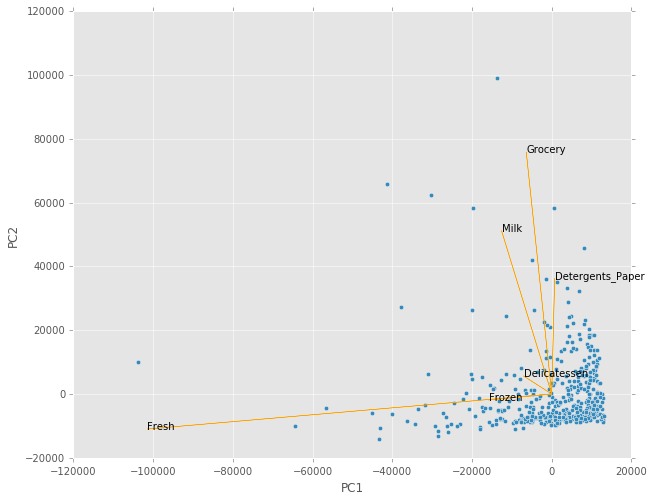

In [3]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=data.shape[1])
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print ''
print pca.explained_variance_ratio_

x = np.arange(6)
plt.plot(x, 1 - np.cumsum(pca.explained_variance_ratio_), 'g-o')

def abs_max(data):
    xmax, ymax = data.max(axis=0)
    xmin, ymin = data.min(axis=0)
    
    return max(abs(xmax), abs(xmin)), max(abs(ymax), abs(ymin))

def biplot(df):
    
    reduced_fit = PCA(n_components=2).fit(data)
    reduced_data = reduced_fit.transform(data)
    
    xmax, ymax = abs_max(reduced_data)
        
    ax = pd.DataFrame(reduced_data, columns=['PC1', 'PC2']
                     ).plot(kind='scatter', x='PC1', y='PC2', figsize=(10, 8))
    
    # Plot arrows and labels
    for i, (pc1, pc2) in enumerate(zip(pca.components_[0], pca.components_[1])):
        ax.arrow(0, 0, pc1*xmax, pc2*ymax, width=2, fc='orange', ec='orange')
        ax.annotate(df.columns[i], (pc1*xmax, pc2*ymax), size=10)

    return ax

ax = biplot(data)

**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: 

The first and second Principal Component variances are 0.46 and 0.41, respectively. However, it quickly drops offs from there to 0.07. The 2nd dimension, when ranking the variances from from highest to lowest, would be the point of diminishing returns. Adding any additional dimensions after this, would not significantly increase the variance. For this reason, I would choose two dimensions.

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: 

Each of the components represents a different axis in the data, and how much this axis describes the features of the data set. Inside of each component is  the correlation of that component with each feature. Component one is highly  correlated with "Fresh", reflecting that it mostly contains data on "Fresh" products. The second component highly correlated with "Milk" and "Grocery" labels, meaning this segment mostly contains these products.

PCA is used for feature selection. So we can use the first two principal components (PC1 and PC2), and apply their "loadings" or correlations to each row of data. We can then create a graph of the data using PC1 on one axis, and PC2 on the other. From there we can plot each row of data, and the result will show us the customer data in a two dimensional way.

Using this graph, along with the correlations produced from each component, we can recognize some patterns in the data. For example, we notice that high volume customers purchase a lot of "Fresh" products, and some "Frozen" products, but low volume customers rarely do so. Vendors who purchase Milk, Grocery, and Detergent_Paper products are a lot less like to purchase Delicatessen products. They also have little-to-no demand for Frozen and Fresh products. The wholesaler has many more smaller volume customer than larger volume customers and lower volume customers are much more likely to purchase deli products.

From here, we can use a clustering algorithm, such as K-means, to segment the data into different cohorts.

###ICA

   Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  0.097  0.011   -0.072  -0.678             0.022         0.285
1  0.043  0.016    0.055   0.032            -0.021        -0.867
2  0.018  0.719   -0.554  -0.020             0.155        -0.287
3 -0.446  0.066    0.073   0.040            -0.100         0.045
4  0.022 -0.127    0.695   0.016            -0.134        -0.094
5 -0.029  0.193    1.052  -0.091            -1.140        -0.273


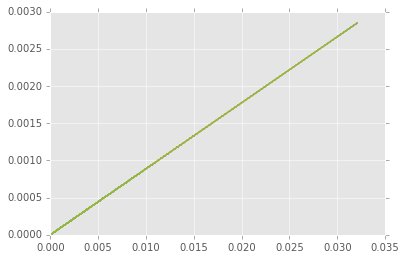

In [4]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

ica = FastICA()
ica.fit(scaled_data)
# Print the independent components
ica_df = pd.DataFrame(np.around(ica.components_, decimals=3), columns=data.columns.values)
print ica_df


import matplotlib.pyplot as plt

ica_1 = ica.transform(scaled_data)[0]

plt.plot(ica_1[0]*scaled_data, ica_1[1]*scaled_data)
plt.show()


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: 

Each row in the ICA composition represents a vector of the weightings of each feature. In component one, features, Fresh, Milk, Grocery and Detergents_Paper appear have low weightings, while Frozen and Delicatessen have high weightings, which could be representing stores that sell frozen food or deli food such as a Bodega, but not in the same quantity. The Frozen weighting is 0.678 and the Delicatessen weighting is -0.285, implying that for every 2 purchases of frozen food, they purchase one deli product. In component two, all of the loadings are low, with the exception of Fresh, implying this might be a "Fresh", organic store, such as Whole Foods. Component three has a high negative weighting in Grocery, representing a standard grocery store. The fourth component has a high negative weight in Milk and positive weight Grocery, implying it's a grocery store or a gas station that sells milk. Component five is definitely a Delicatessen, given its very high weighting. Finally, component six is most likely a grocery store or a convenience store, given it has a positive high weighting in Grocery and negative high weighting in Detergent_Paper products. Convenience stores sometimes sell groceries, but are more like to sell paper products.

ICA can help us find the latent features in a data set. The components generated above give us insight into the distributor's different customer groups. Each customer group has different purchasing habits. For example the customers in component one, most likely are gas stations or bodegas who sell Frozen and Deli products, but in different quantities. This segmentation can be used to test new procedures and make future decisions related to pricing, and product logistics, and more.

##Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

###Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: 

K Means clustering is one of the simplest clustering algorithms. It works well with large data sets, and is often faster than a hierarchical cluster, when K is small. It also tends to produce tighter clusters and each cluster is hard assigned. However, it's difficult to pick the K value and it doesn't work well with non-global clusters. Additionally it can fail if it falls into a local minima, which is why it is important to repeat it several times. It fails with non-linear data, and different representations of the data will produce different results.

Gaussian Mixture Models (GMM) have well established statistical inference techniques. We can think of GMM as generalizing K Means to return the covariance structure of the data as well as the centers of the Gaussians. We can obtain a density estimation for each cluster using this method. GMM is the fastest mixture model algorithm, and its clusters are soft assigned.

I chose to use K Means because of it's simplicity and faster compute time. K means has to calculate the mean of the data for each cluster, while GMM has to calculate the mean and standard deviation to build a maximum Gaussian distribution. GMM also uses soft assignment for the clusters, so it may require more data points to create an accurate prediction.

http://www.improvedoutcomes.com/docs/WebSiteDocs/Clustering/K-Means_Clustering_Overview.htm

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

http://scikit-learn.org/stable/modules/mixture.html

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [5]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [6]:
# First we reduce the data to two dimensions using PCA to capture variation
reduced_fit = PCA(n_components=2).fit(data)
reduced_data = reduced_fit.transform(data)
print reduced_data[:10]  # print upto 10 elements

[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


In [7]:
def create_cluster_graph(n_clusters):
    # Implement your clustering algorithm here, and fit it to the reduced data for visualization
    # The visualizer below assumes your clustering object is named 'clusters'
    
    clusters = KMeans(n_clusters=n_clusters).fit(reduced_data)
    
    # Plot the decision boundary by building a mesh grid to populate a graph.
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    hx = (x_max-x_min)/1000.
    hy = (y_max-y_min)/1000.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Find the centroids for KMeans or the cluster means for GMM 

    centroids = clusters.cluster_centers_
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    figure_number = n_clusters-1
    plt.figure(figure_number)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross ' + str(figure_number))
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    # plt.xticks(())
    # plt.yticks(())
    plt.show()

    centroid_inverse_transformed = reduced_fit.inverse_transform(centroids)
    stacked_data = np.hstack((centroids, centroid_inverse_transformed))
    columns = np.concatenate((['x', 'y'],data.columns.values))
    centroid_makeup = pd.DataFrame(np.around(stacked_data), columns=columns)
    ax = centroid_makeup.drop(['x','y'], axis=1).plot(kind = 'bar', figsize = (12, 6))

    print centroid_makeup

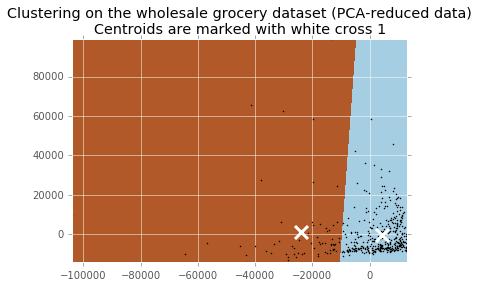

         x       y    Fresh    Milk  Grocery  Frozen  Detergents_Paper  \
0   4175.0  -211.0   7946.0  5181.0   7533.0  2440.0            2834.0   
1 -24088.0  1218.0  35389.0  9344.0  10365.0  6719.0            3157.0   

   Delicatessen  
0        1228.0  
1        3235.0  


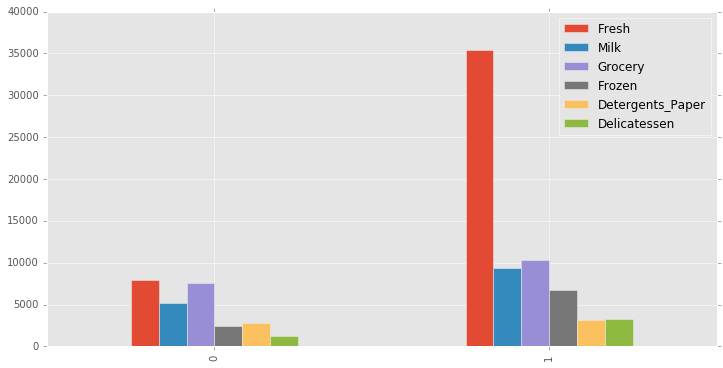

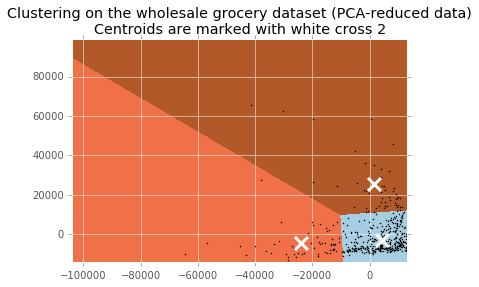

         x        y    Fresh     Milk  Grocery  Frozen  Detergents_Paper  \
0   4165.0  -3105.0   8276.0   3690.0   5321.0  2495.0            1776.0   
1 -23979.0  -4446.0  35908.0   6409.0   6028.0  6809.0            1088.0   
2   1341.0  25261.0   7896.0  18664.0  27184.0  2395.0           12120.0   

   Delicatessen  
0        1064.0  
1        2904.0  
2        2875.0  


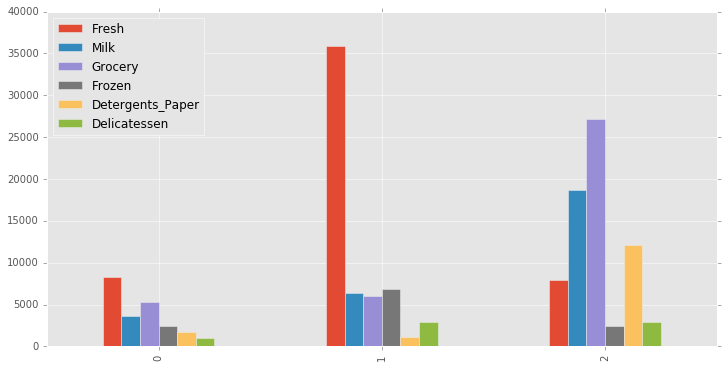

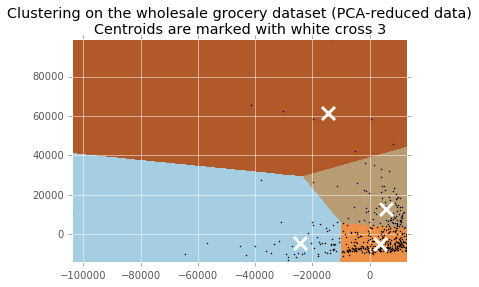

         x        y    Fresh     Milk  Grocery  Frozen  Detergents_Paper  \
0 -24221.0  -4364.0  36135.0   6480.0   6105.0  6844.0            1116.0   
1   5672.0  12760.0   5050.0  11691.0  17359.0  1969.0            7583.0   
2   3563.0  -4907.0   9064.0   2833.0   3980.0  2621.0            1114.0   
3 -14538.0  61716.0  19370.0  39391.0  56034.0  4131.0           25327.0   

   Delicatessen  
0        2925.0  
1        1867.0  
2        1002.0  
3        6038.0  


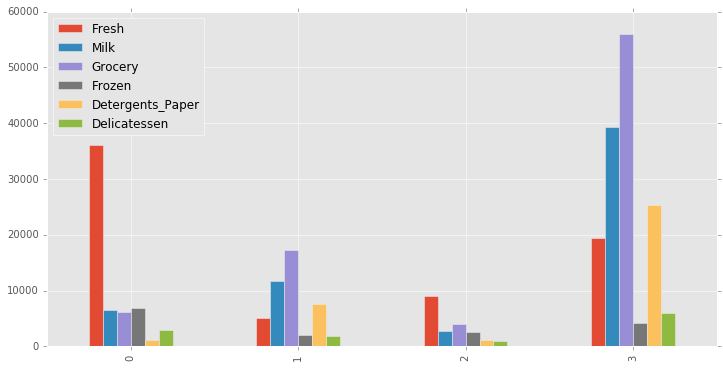

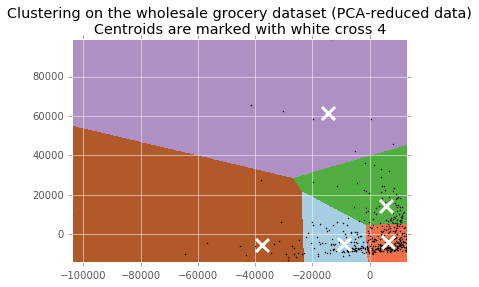

         x        y    Fresh     Milk  Grocery  Frozen  Detergents_Paper  \
0  -9052.0  -4809.0  21372.0   4413.0   4832.0  4541.0            1061.0   
1   5608.0  14199.0   4953.0  12441.0  18463.0  1952.0            8109.0   
2   6400.0  -4169.0   6212.0   2870.0   4370.0  2175.0            1403.0   
3 -14538.0  61716.0  19370.0  39391.0  56034.0  4131.0           25327.0   
4 -37705.0  -5488.0  49427.0   7535.0   6075.0  8920.0             610.0   

   Delicatessen  
0        1867.0  
1        1953.0  
2         851.0  
3        6038.0  
4        3779.0  


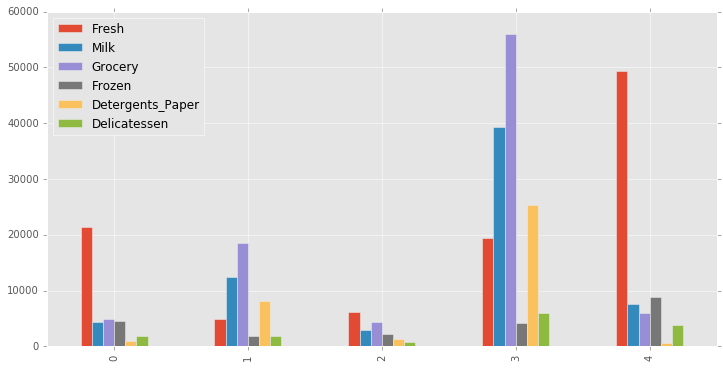

In [8]:
# Run the clustering 4 times, displaying a graph and table for each number of clusters
for x in range(2, 6):
    create_cluster_graph(x)

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: 

In order to determine the number of clusters to use for K-Means, I ran algorithm 4 times, each with a different k value (2 - 5). Each time it was ran, I output the cluster graph as well as a table showing the feature makeup for each cluster. After analyzing both the graph and the table, I decided to use three clusters. 

A K value of 3 produced the most intuitive result. The feature table also provided strong supporting data for distinct segmenting amongst the customers, while higher K values have some overlapping makeups.

The customer segments can be described as being customers who purchase [1] Milk, Grocery, Detergent and Paper products (which may be grocery stores, and convenience stores), [2] Fresh products (most likely high-end organic market places such as Whole Foods), and finally [3] a variety of products (superstore centers, or convenience stores).

###Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: 

Principal Component Analysis (PCA) is used to reduce the dimensionality of the data. The principal component is the direction that has the largest variance, because it retains the maximum amount of information from the original data. It minimizes the distance from the old, higher dimensional data points into its new transformed values, which in turn minimizes information loss. The second principal component is orthogonal (perpendicular) to the first, and it is the the axis with second most variation. PCA is great for discovering which latent features are driving patterns in the data. Using this technique, we can reduce the dimensionality of the wholesale data from 6 to 2 dimensions. This dimensionality reduction makes it much easier to interpret and work with the data, however this doesn’t cluster the data into distinct groups. In order to group the data, we’ll need to use a clustering algorithm such as K-Means.

Independent Component Analysis (ICA), as the name might imply, helps separate independent sources which are linearly mixed. ICA is commonly used to separate different sound sources from multiple microphone inputs, but it can be applied to other data sets. ICA removes any correlations in the data through a process called whitening (also known as sphering). After whitening, ICA rotates the data back to the original space by minimizing the Gaussian of the data. Using this technique on our data set, we can isolate the underlying factors and the weightings, allowing us to group the wholesalers customers based on their purchasing habits. Unfortunately ICA does not ranking the components, and since we didn’t specify the number of components to returns, we’re left to interpret ourselves the most important vectors.

PCA, combined with K Means was by far the most easy to understand. PCA allowed me to reduce the data to two dimensions, and cluster the data into distinct cohorts. I ran the clustering algorithm several times, outputting a graph of the clusters as well as a table which mapped the clustered data back to the original feature set.

**9)** How would you use that technique to help the company design new experiments?

Answer: 

Given that we are now able to segment the customers, we can run isolated experiments on these cohorts, and see how each of them react. Experiments could include new shipping methods, like the one they previously implemented, new packaging materials, different carriers, different price points, etc. The different segments may react differently to each experiment, and in some scenarios it might make sense to implement a new procedure for a specific segment, but exclude others. Other experiments might results in consistent reactions.

**10)** How would you use that data to help you predict future customer needs?

Answer: 

Given that we know our current customer segments, we can easily classify future customers into specific segments and provide them with the most appropriate set of services. As our customers grow and purchasing habits change, we can predict what sort of service offering they will need.

We could could label customers into different groupings, determined by the K-Means process mentioned above, and run this labeled data through a classification algorithm, such as SVM, so that we can classify future customers. We could use a combination of regression and classification algorithms to predict when a particular customer, or cohort of customers, will purchase some goods, at what price they're willing to pay for those goods, and in what quantity.
